In [8]:
from scipy.optimize import minimize
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def two_tank_model(t, c, V1, V2, c_inlet):
    q = .03
    k = .0062
    18
    n = 2.4
    c1, c2 = c
    dc1dt = q/V1*(c_inlet - c1) - k*np.power(c1, n)
    dc2dt = q/V2*(c1 - c2) - k*c2**n
    return np.array([dc1dt, dc2dt])

def run_simulation(V1, V2, c_inlet):
    x = fsolve(lambda c: two_tank_model(0, c, V1, V2, c_inlet), [10, 10]) # The␣last input argument here is the initial guess for the solver. 10 are good␣values, they are in the middle of our constraint.
    c_out1, c_out2 = x
    return c_out1, c_out2

def objective(V, print_vals = False):
    if V.shape[0] == 2:
        V1, V2 = V
    else:
        V1 = V[0]
        V2 = 20.0 - V1
    c_inlet = 20.0
    c_out1, c_out2 = run_simulation(V1, V2, c_inlet)
    conversion = (c_inlet - c_out2)/c_inlet
    if print_vals:
        print(f'V1 = {V1}, V2 = {V2}, conversion = {conversion}')
    return 1-conversion

def constraint(V):
    V_total = 20
    return V_total - V[0] - V[1]

In [10]:
eq_constr = {'type': 'eq',
            'fun': constraint,
            }

ineq_constr = {'type': 'ineq',
                'fun': constraint,
                }

In [11]:
print('Optimization with equality constraint')
res_eq = minimize(lambda V: objective(V, print_vals = False),
                    x0 = np.array([10, 10]),
                    method = 'SLSQP',
                    bounds = ((1e-3, np.inf),
                    (1e-3, np.inf)),
                    constraints = eq_constr,
                    options = {'disp': True,
                    'ftol': 1e-8},
                    )
optimal_conversion_eq = 1-objective(res_eq.x)
print(f'Optimal conversion: {optimal_conversion_eq}')

Optimization with equality constraint
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04358416307248536
            Iterations: 9
            Function evaluations: 27
            Gradient evaluations: 9
Optimal conversion: 0.9564158369275146


C:\Users\olofs\AppData\Local\Temp\ipykernel_21176\3825849158.py:7: RuntimeWarning: invalid value encountered in power
  dc1dt = q/V1*(c_inlet - c1) - k*np.power(c1, n)


In [12]:
print('Optimization with inequality constraint')
res_ineq = minimize(lambda V: objective(V, print_vals = False),
                    x0 = np.array([10, 10]),
                    method = 'SLSQP',
                    bounds = ((1e-3, np.inf),
                    (1e-3, np.inf)),
                    constraints = ineq_constr,
                    options = {'disp': True,
                    'ftol': 1e-8},
                    )
optimal_conversion_ineq = 1-objective(res_ineq.x)
print(f'Optimal conversion with equality constraint: {optimal_conversion_eq}')

Optimization with inequality constraint
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04358416307248536
            Iterations: 9
            Function evaluations: 27
            Gradient evaluations: 9
Optimal conversion with equality constraint: 0.9564158369275146


C:\Users\olofs\AppData\Local\Temp\ipykernel_21176\3825849158.py:7: RuntimeWarning: invalid value encountered in power
  dc1dt = q/V1*(c_inlet - c1) - k*np.power(c1, n)


In [13]:
V1_ar = np.linspace(1, 19, 20)
V2_ar = np.linspace(1, 19, 20)
# Response surface
X, Y = np.meshgrid(V1_ar, V2_ar)
Z = np.zeros(X.shape)
for i, V1 in enumerate(V1_ar):
    for j, V2 in enumerate(V2_ar):
        Z[i, j] = 1-objective(np.array([V1, V2]))
# Constraint line
V2_constr_ar = 20 - V1_ar
Z_constr = np.zeros(V1_ar.shape)
for i, V1 in enumerate(V1_ar):
    Z_constr[i] = 1-objective(np.array([V1, V2_constr_ar[i]]))

C:\Users\olofs\AppData\Local\Temp\ipykernel_21176\3825849158.py:8: RuntimeWarning: invalid value encountered in scalar power
  dc2dt = q/V2*(c1 - c2) - k*c2**n
C:\Users\olofs\AppData\Local\Temp\ipykernel_21176\3825849158.py:7: RuntimeWarning: invalid value encountered in power
  dc1dt = q/V1*(c_inlet - c1) - k*np.power(c1, n)


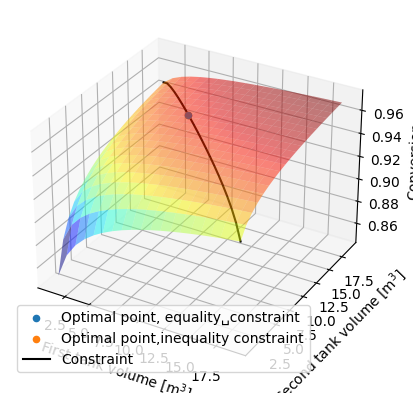

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# This is the surface plot
ax.plot_surface(X, Y, Z.T, alpha = .5, cmap = 'jet')
# These are the plots of the two optimum points
ax.scatter(*res_eq.x, optimal_conversion_eq, label = "Optimal point, equality␣constraint")
ax.scatter(*res_ineq.x, optimal_conversion_ineq, label = "Optimal point,inequality constraint")
# And finally, we plot the constraint line!
ax.plot(V1_ar, V2_constr_ar, Z_constr, label ="Constraint", color = 'k')
ax.set_xlabel(r'First tank volume [m$^{3}$]')
ax.set_ylabel(r'Second tank volume [m$^{3}$]')
ax.set_zlabel('Conversion')
ax.legend()